# Prediksi Karies

In [1]:
# BLOCK 1: Install dan Import Libraries
# Jalankan ini terlebih dahulu
!pip install opencv-python-headless

In [2]:
import numpy as np
import cv2
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from google.colab import drive
from google.colab import files

In [9]:
class SimpleKariesPredictor:
    def __init__(self, model_path):
        self.model = load_model(model_path)
        self.img_size = (224, 224)  # Sesuaikan dengan ukuran input model Anda
        self.class_names = ['Karies', 'Sehat']  # Sesuaikan dengan label model Anda
        print(f"Model berhasil dimuat dari: {model_path}")

    def preprocess_for_model(self, image_crop):
        """Preprocessing gambar untuk model"""
        try:
            if len(image_crop.shape) == 3:
                image_crop = cv2.cvtColor(image_crop, cv2.COLOR_BGR2GRAY)

            image_crop = cv2.resize(image_crop, self.img_size)
            image_crop = image_crop.astype('float32') / 255.0

            if len(image_crop.shape) == 2:
                image_crop = np.stack([image_crop] * 3, axis=-1)

            image_crop = np.expand_dims(image_crop, axis=0)
            return image_crop

        except Exception as e:
            print(f"Error dalam preprocessing: {e}")
            return None

    def detect_teeth_regions(self, image):
        """Deteksi region gigi pada citra panoramik"""
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image.copy()

        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        enhanced = clahe.apply(blurred)

        _, thresh = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
        opened = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
        closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel)

        contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        teeth_regions = []
        min_area = 500
        max_area = 5000

        for contour in contours:
            area = cv2.contourArea(contour)
            if min_area < area < max_area:
                x, y, w, h = cv2.boundingRect(contour)
                aspect_ratio = w / h
                if 0.3 < aspect_ratio < 3.0:
                    teeth_regions.append((x, y, w, h))

        return teeth_regions

    def predict_panoramic(self, image_path):
        """
        Prediksi panoramik - hanya return hasil akhir
        Returns: "Karies" atau "Tidak Ada Karies"
        """
        image = cv2.imread(image_path)
        if image is None:
            return "Error: Gagal membaca gambar"

        teeth_regions = self.detect_teeth_regions(image)

        if not teeth_regions:
            return "Error: Tidak ada gigi yang terdeteksi"

        # Cek setiap gigi yang terdeteksi
        for x, y, w, h in teeth_regions:
            tooth_crop = image[y:y+h, x:x+w]
            processed_tooth = self.preprocess_for_model(tooth_crop)

            if processed_tooth is not None:
                prediction = self.model.predict(processed_tooth, verbose=0)
                predicted_class_idx = np.argmax(prediction)
                predicted_class = self.class_names[predicted_class_idx]

                # Jika ditemukan satu gigi karies, langsung return "Karies"
                if predicted_class == 'Karies':
                    return "Karies"

        # Jika semua gigi sehat
        return "Tidak Ada Karies"

    def show_result(self, image_path, result):
        """Tampilkan gambar dengan hasil prediksi"""
        image = cv2.imread(image_path)
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(10, 6))
        plt.imshow(image, cmap='gray')

        # Warna title berdasarkan hasil
        title_color = 'red' if result == 'Karies' else 'green'
        plt.title(f'Hasil Prediksi: {result}', fontsize=16, color=title_color, fontweight='bold')
        plt.axis('off')
        plt.show()


In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
MODEL_PATH = "/content/drive/MyDrive/TA/database2/hasilta6/model_karies_gigi_final.h5"
try:
    predictor = SimpleKariesPredictor(MODEL_PATH)
    print("Predictor siap digunakan!")
except Exception as e:
    print(f"Error loading model: {e}")

Model berhasil dimuat dari: /content/drive/MyDrive/TA/database2/hasilta6/model_karies_gigi_final.h5
Predictor siap digunakan!


# Prediksi

In [23]:
# BLOCK 5: Upload Gambar
print("Upload gambar panoramik yang ingin dianalisis")

uploaded_images = files.upload()
IMAGE_PATH = list(uploaded_images.keys())[0]

Upload gambar panoramik yang ingin dianalisis


Saving 34.jpg to 34 (2).jpg



HASIL PREDIKSI: Karies


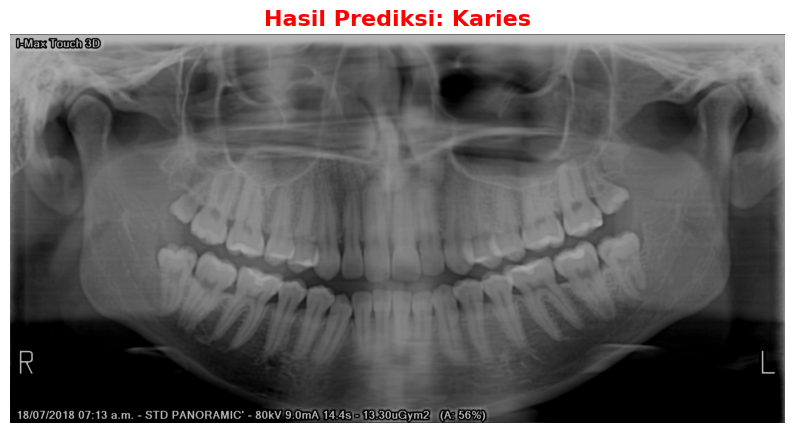

In [24]:
try:
    # Prediksi
    result = predictor.predict_panoramic(IMAGE_PATH)

    # Tampilkan hasil
    print(f"\nHASIL PREDIKSI: {result}")

    # Tampilkan gambar dengan hasil
    if not result.startswith("Error"):
        predictor.show_result(IMAGE_PATH, result)

except Exception as e:
    print(f"Error: {e}")